<div style="text-align: center;">
    <h1><strong>Alma Mater Studiorum - University of Bologna</strong></h1>
    

<div style="display:flex; justify-content:center; align-items:center; padding:5px;">
        <img src="../reports/figs/image.png" style="height:300px; width:auto">
    </div>

<h2><strong>Optimal Control and Reinforcement Learning</strong></h2>

<h3><strong>PROYECT</strong><br>
    <strong>Optimal Control of a Gymnast Robot.</strong></h3>

<p><strong>STUDENTS</strong></p>
    <ul style="list-style-type:none; padding: 0;">
        <li><strong>Rubén Gil Martínez<strong></li>
        <li><strong>Guillermo López Pérez<strong></li>
    </ul>
</div>

1. **The State Space**

The system has two degrees of freedom (DoF) but is underactuated (only torque $\tau$ on the second joint). Let $q = [\theta_1, \theta_2]^\top$ and $\dot{q} = [\dot{\theta}_1, \dot{\theta}_2]^\top$. The state vector is $x = [\theta_1, \theta_2, \dot{\theta}_1, \dot{\theta}_2]^\top \in \mathbb{R}^4$. The control input is $u = [\tau] \in \mathbb{R}^1$.

2. **The Equations of Motion**

The material provides the dynamics in the standard manipulator form:

$$M(q)\ddot{q} + C(q, \dot{q})\dot{q} + F\dot{q} + G(q) = \begin{bmatrix} 0 \\ \tau \end{bmatrix}$$To simulate this, we need the forward dynamics (solving for acceleration):$$\ddot{q} = M(q)^{-1} \left( \begin{bmatrix} 0 \\ \tau \end{bmatrix} - C(q, \dot{q})\dot{q} - F\dot{q} - G(q) \right)$$

**Note**: We have to take into account that the mass matrix $M(q)$ is generally positive definite and invertible for physical robotic arms, so $M^{-1}$ eqists.

3. **System Parameters (Set 3)**

For this implementation, we will strictly adhere to Parameter Set 3 as defined in the project specifications. These parameters describe a robot with specific inertial properties, which will directly impact the control effort required for the swing-up maneuver. The configuration is as follows: 

- Masses: $m_1 = 1.5$ kg, $m_2 = 1.5$ kg
- Link Lengths: $l_1 = 2$ m, $l_2 = 2$ m
- Center of Mass Distances: $l_{c1} = 1$ m, $l_{c2} = 1$ m
- Moments of Inertia: $I_1 = 2$ kg·m², $I_2 = 2$ kg·m²
- Dynamics Constants: Gravity $g = 9.81$ m/s², Viscous Friction $f_1 = 1.0$, $f_2 = 1.0$

This precise set of physical constants must be hardcoded into our dynamics function to ensure our simulation matches the project requirements.

## **Task 0 - Modeling and Discretization** ("The simulator")

In this step we must translate the continuous analytical equations of motion into a discrete-time computational model suitable for optimization.

To ensure high accuracy and numerical stability—critical for the subsequent Newton-type optimization—we will employ the **Runge-Kutta 4th Order (RK4)** method rather than a simple Euler integration. 

Given the continuous dynamics $\dot{x} = f_c(x(t), u(t))$ and a sampling interval $d_t$, the discrete update $x_{t+1} = f_d(x_t, u_t)$ is calculated as follows:

$$\begin{aligned}
k_1 &= f_c(x_t, u_t) \\
k_2 &= f_c(x_t + \frac{d_t}{2} k_1, u_t) \\
k_3 &= f_c(x_t + \frac{d_t}{2} k_2, u_t) \\
k_4 &= f_c(x_t + d_t \, k_3, u_t) \\
x_{t+1} &= x_t + \frac{d_t}{6} (k_1 + 2k_2 + 2k_3 + k_4)
\end{aligned}$$


**Why continuous dynamics returns x_dot?**

The continuous_dynamics function solves the equations of motion (Newton's Laws) derived from the Lagrangian dynamics.
$$M(q)\ddot{q} + C\dot{q} + F\dot{q} + G = \tau$$
To solve this, we isolate acceleration ($\ddot{q}$). Since our state vector $x$ includes velocity, the derivative of the state vector $\dot{x}$ is:$$\dot{x} = \frac{d}{dt} \begin{bmatrix} q \\ \dot{q} \end{bmatrix} = \begin{bmatrix} \dot{q} \\ \ddot{q} \end{bmatrix}$$

- The first half of x_dot is just the velocity (which we already have in $x$).
- The second half of x_dot is the acceleration (which we just calculated using $M^{-1}(F_{forces})$).

So, continuous_dynamics strictly calculates the slope of the trajectory at the current instant.

**How RK4 uses this slope?**

The RK4 solver needs to know the slope ($\dot{x}$) at four different points to estimate the curve accurately.

1) k1: Slope at the start of the step.
2) k2 & k3: Slopes at the midpoint of the step.
3) k4: Slope at the end of the step.

Therefore, The computed $x_{t+1} = f_d(x_t, u_t)$ is the actual "Discrete State Equation". It takes the current position $x$ and adds the weighted average of those slopes multiplied by the time step $dt$.

In [12]:
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

import numpy as np
from numpy.linalg import inv


In [13]:
class Acrobot:
    def __init__(self):
        # Initialize with Parameter Set 3 
        self.params = {
            'm1': 1.5,
            'm2': 1.5,
            'l1': 2.0,
            'l2': 2.0,
            'lc1': 1.0,
            'lc2': 1.0,
            'I1': 2.0,
            'I2': 2.0,
            'g': 9.81,
            'f1': 1.0,
            'f2': 1.0
        }
        
        
        self.m1, self.m2 = self.params['m1'], self.params['m2']
        self.l1, self.l2 = self.params['l1'], self.params['l2']
        self.lc1, self.lc2 = self.params['lc1'], self.params['lc2']
        self.I1, self.I2 = self.params['I1'], self.params['I2']
        self.g = self.params['g']
        self.f1, self.f2 = self.params['f1'], self.params['f2']



    def get_matrices(self, x):
        """
        Computes M, C, G, F matrices based on current state x.
        x = [theta1, theta2, dtheta1, dtheta2]
        """
        theta1 = x[0]
        theta2 = x[1]
        dtheta1 = x[2]
        dtheta2 = x[3]

        # Common terms to save computation
        c2 = np.cos(theta2)
        s2 = np.sin(theta2)
        s1 = np.sin(theta1)
        s12 = np.sin(theta1 + theta2)



        # 1. Mass Matrix M
        # M11 = I1 + I2 + lc1^2*m1 + m2*(l1^2 + 2*l1*lc2*cos(theta2) + lc2^2)
        m11 = self.I1 + self.I2 + (self.lc1**2)*self.m1 + \
              self.m2 * (self.l1**2 + 2*self.l1*self.lc2*c2 + self.lc2**2)
        
        # M12 = I2 + lc2*m2*(l1*cos(theta2) + lc2)
        m12 = self.I2 + self.lc2 * self.m2 * (self.l1*c2 + self.lc2)
        
        # M21 = M12 (Symmetric)
        m21 = m12
        
        # M22 = I2 + lc2^2*m2
        m22 = self.I2 + (self.lc2**2) * self.m2
        
        M = np.array([[m11, m12],
                      [m21, m22]])




        # 2. Coriolis Matrix C
        # C11 = -l1*lc2*m2*dtheta2*sin(theta2)
        c11 = -self.l1 * self.lc2 * self.m2 * dtheta2 * s2
        
        # C12 = -l1*lc2*m2*(dtheta1 + dtheta2)*sin(theta2)
        c12 = -self.l1 * self.lc2 * self.m2 * (dtheta1 + dtheta2) * s2
        
        # C21 = l1*lc2*m2*dtheta1*sin(theta2)
        c21 = self.l1 * self.lc2 * self.m2 * dtheta1 * s2
        
        # C22 = 0
        c22 = 0.0
        
        C = np.array([[c11, c12],
                      [c21, c22]])





        # 3. Gravity Vector G(q)
        # G1 = g*lc1*m1*sin(theta1) + g*m2*(l1*sin(theta1) + lc2*sin(theta1+theta2))
        g1 = self.g * self.lc1 * self.m1 * s1 + self.g * self.m2 * (self.l1 * s1) + self.lc2 * s12
        
        # G2 = g*m2*lc2*sin(theta1+theta2)
        g2 = self.g * self.m2 * self.lc2 * s12

        G = np.array([[g1],
                      [g2]])






        # 4. Friction Matrix F
        F = np.array([[self.f1, 0.0],
                      [0.0, self.f2]])

        return M, C, G, F
    



    # This is literally f_c(x(t), u(t)) ---> the physics behind the system
    def continuous_dynamics(self, x, u):
        """
        Computes x_dot(jacobians) = f(x, u)
        State x = [theta1, theta2, dtheta1, dtheta2]
        Input u = [tau] (scalar torque on second link)
        """
        # Get system matrices
        M, C, G, F = self.get_matrices(x)
        
        # State velocity vector q_dot = [dtheta1, dtheta2]
        q_dot = np.array([[x[2]], 
                          [x[3]]])
        
        # Input vector (Torque only on second joint)
        # u is expected to be an array or list, so we access u[0]
        tau_vec = np.array([[0], 
                            [u[0]]])
        


        # Solve for acceleration q_ddot
        # Equation: M * q_ddot + C * q_dot + F * q_dot + G = tau_vec
        # Rearranged: q_ddot = inv(M) * (tau_vec - C*q_dot - F*q_dot - G)
        
        # Compute the "forces" term
        forces = tau_vec - (C @ q_dot) - (F @ q_dot) - G
        
        # Solve linear system M * q_ddot = forces (faster and more stable than inv(M))
        q_ddot = np.linalg.solve(M, forces)
        
        # Construct the full state derivative x_dot
        # x_dot = [dtheta1, dtheta2, ddtheta1, ddtheta2]
        x_dot = np.concatenate((q_dot.flatten(), q_ddot.flatten()))
        
        return x_dot
    


    def discrete_step_rk4(self, x, u, dt):
        """
        Implements Runge-Kutta 4th Order (RK4) integration 
        x_next = x + (dt/6) * (k1 + 2k2 + 2k3 + k4)
        """
        # k1
        k1 = self.continuous_dynamics(x, u)
        
        # k2
        k2 = self.continuous_dynamics(x + 0.5 * dt * k1, u)
        
        # k3
        k3 = self.continuous_dynamics(x + 0.5 * dt * k2, u)
        
        # k4
        k4 = self.continuous_dynamics(x + dt * k3, u)
        
        # Update rule
        x_next = x + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
        
        return x_next


if __name__ == "__main__":
    # Instantiate robot with Parameter Set 3
    robot = Acrobot()
    
    # Define an initial state: hanging down, slightly moving
    x0 = np.array([0.5, 0.25, 0.0, 0.0]) 
    
    # Define a control input 
    u0 = np.array([1.5])
    
    # Time step
    dt = 0.01
    
    # Perform one step
    x_next = robot.discrete_step_rk4(x0, u0, dt)
    
    print("Initial State:", x0)
    print("Control Input:", u0)
    print("Next State (RK4):", x_next)

Initial State: [0.5  0.25 0.   0.  ]
Control Input: [1.5]
Next State (RK4): [ 0.49995602  0.24995869 -0.00879796 -0.00825504]


## **Task 1 - Trajectory Generation (I)** 

**Step 1: Compute the Equilibria**

An equilibrium is a state where the robot stays still if no force is applied (or a constant holding torque). Mathematically, this means acceleration and velocity are zero: $\ddot{q} = 0, \dot{q} = 0$. We solve the equation:$$f(x, u=0) = 0$$Since gravity $G(q)$ is non-linear, we use a root-finder to find the exact angles.


**Step 2: Define the Reference Curve (The "Step" Input)**

As shown in Figure 2 of the assignment, the reference is not a complex curve but a "step" command. First half of time: We tell the robot "stay at the bottom" ($x_{eq1}$). Second half of time: We tell the robot "stay at the top" ($x_{eq2}$). Our optimization algorithm (Newton's method) will later calculate the smooth transition to make this possible.


**Step 3: The Optimization Loop**

Once we have the start ($x_{eq1}$), the end ($x_{eq2}$), and the reference, we will implement the Newton-type optimal control. This involves:

1. Forward Pass: Simulate the robot with current controls (First iteration: $u=0$).

2. Backward Pass: Calculate derivatives (gradients/Hessians) to see how to improve the controls.

3. Update: Adjust $u$ to minimize the error between the robot's path and the reference curve.

In [ ]:
class NewtonSolver:
    def __init__(self, robot):
        self.robot = robot
        self.dt = 0.01
        self.T_horizon = 10.0  # Total time for swing-up
        self.N = int(self.T_horizon / self.dt)
        
       
        # Q: State penalty. High penalty on angles to force tracking.
        self.Q = np.zeros((4, 4))
        self.Q[0,0] = 10.0   # Theta1
        self.Q[1,1] = 10.0   # Theta2
        self.Q[2,2] = 0.1    # Velocity 1
        self.Q[3,3] = 0.1    # Velocity 2
        
        # R: Control penalty. 
        # Lower R = More aggressive torque allowed.
        self.R = np.eye(1) * 0.01 
        
        # Q_final: Terminal cost. Very high to ensure we land on the target.
        self.Q_final = np.zeros((4, 4))
        self.Q_final[0,0] = 5000.0
        self.Q_final[1,1] = 5000.0
        self.Q_final[2,2] = 1000.0
        self.Q_final[3,3] = 1000.0

        # Storage for plots
        self.cost_history = []
        self.descent_norm_history = []
        self.armijo_alphas = []
        self.intermediate_trajs = [] # To store x trajectories at iterations 0, 1, 5...






    def compute_equilibria(self):
        """
        Solves f(x, 0) = 0 using root finding.
        """
        def residuals(q_guess):
            # Form full state with 0 velocity
            x_test = np.array([q_guess[0], q_guess[1], 0.0, 0.0])
            u_zero = np.array([0.0])
            # Return accelerations (must be 0)
            return self.robot.continuous_dynamics(x_test, u_zero)[2:]

        # 1. Down Equilibrium
        q_down = fsolve(residuals, [0.0, 0.0])
        self.x_eq1 = np.array([q_down[0], q_down[1], 0.0, 0.0])
        
        # 2. Up Equilibrium (Inverted)
        q_up = fsolve(residuals, [np.pi, 0.0])
        self.x_eq2 = np.array([q_up[0], q_up[1], 0.0, 0.0])
        
        # Verify inputs required
        # u_eq2 should be ~0 based on physics, but let's calculate it to be precise
        # Inverting dynamics: tau = M*0 + C*0 + G
        # At zero velocity, tau = G(q)
        # We only actuate the second joint, so we check G[1]
        _, _, G_up, _ = self.robot.get_matrices(self.x_eq2)
        self.u_eq2 = G_up[1] # Should be effectively 0
        
        print(f"Equilibrium Down: {self.x_eq1}")
        print(f"Equilibrium Up:   {self.x_eq2}")
        print(f"Torque req at Up: {self.u_eq2}") # likely approx 1e-15 (zero)






    def generate_step_reference(self):
        """
        Creates the step reference trajectory.
        """
        # Time vector
        self.time_grid = np.linspace(0, self.T_horizon, self.N + 1)
        
        self.x_ref = np.zeros((self.N + 1, 4))
        self.u_ref = np.zeros((self.N, 1))
        
        # Split point (T/2)
        split_idx = int(self.N / 2)
        
        # First half: Stay Down
        self.x_ref[:split_idx, :] = self.x_eq1
        
        # Second half: Stay Up
        self.x_ref[split_idx:, :] = self.x_eq2
        
        return self.x_ref, self.u_ref
    







    def get_derivatives_fd(self, x, u):
        """
        Finite Difference calculation of Jacobians A, B.
        """
        eps = 1e-6
        nx, nu = 4, 1
        A = np.zeros((nx, nx)) # shape (4,4)
        B = np.zeros((nx, nu)) # shape (4,1)
        
        # Center point 
        f0 = self.robot.discrete_step_rk4(x, u, self.dt)
        
        for i in range(nx):
            x_inc = x.copy(); x_inc[i] += eps
            f_inc = self.robot.discrete_step_rk4(x_inc, u, self.dt)
            A[:, i] = (f_inc - f0) / eps
            
        for i in range(nu):
            u_inc = u.copy(); u_inc[i] += eps
            f_inc = self.robot.discrete_step_rk4(x, u_inc, self.dt)
            B[:, i] = (f_inc - f0) / eps
            
        return A, B
    






    def cost_func(self, x_traj, u_traj):
        """ Total cost J calculation """
        J = 0
        # Sum of stage costs
        for i in range(self.N):
            x_err = x_traj[i] - self.x_ref[i]
            u_err = u_traj[i] - self.u_ref[i]
            J += 0.5 * (x_err.T @ self.Q @ x_err + u_err.T @ self.R @ u_err)
            
        # Terminal cost
        x_terminal_err = x_traj[-1] - self.x_ref[-1]
        J += 0.5 * x_terminal_err.T @ self.Q_final @ x_terminal_err

        return J
    




    def solve(self, max_iters=50):
        print("Starting Newton-type Optimization with Armijo Verification...")
        
        # 1. Initialization
        u = np.zeros((self.N, 1)) 
        x_traj = np.zeros((self.N + 1, 4))
        x_traj[0] = self.x_eq1
        
        # Initial Rollout
        for i in range(self.N):
            x_traj[i+1] = self.robot.discrete_step_rk4(x_traj[i], u[i], self.dt)
            
        initial_cost = self.cost_func(x_traj, u)
        self.cost_history.append(initial_cost)
        self.intermediate_trajs.append(x_traj.copy())
        
        print(f"Iter 0: Cost {initial_cost:.4f}")

        # Armijo Parameters 
        cc = 0.5
        beta = 0.7
        max_steps_armijo = 20 # Increased slightly for safety




        # Newton Loop
        for it in range(max_iters):
            
            # --- Backward Pass (Riccati) ---
            dx_term = x_traj[-1] - self.x_ref[-1] # Differential between final state and reference
            V_x = self.Q_final @ dx_term 
            V_xx = self.Q_final
            
            k_feedforward = np.zeros((self.N, 1))
            K_feedback = np.zeros((self.N, 1, 4))
            
            # We need to calculate the "Expected Slope" (Directional Derivative)
            # In Optimal Control: slope = sum( Q_u * k )
            expected_slope = 0.0
            descent_norm = 0.0
            
            for i in range(self.N - 1, -1, -1):
                A, B = self.get_derivatives_fd(x_traj[i], u[i]) # Linearization of the dynamics constraints about a trajectory
                
                dx = x_traj[i] - self.x_ref[i]
                du = u[i] - self.u_ref[i]
                
                l_x = self.Q @ dx 
                l_u = self.R @ du
                
                Q_x = l_x + A.T @ V_x
                Q_u = l_u + B.T @ V_x
                Q_xx = self.Q + A.T @ V_xx @ A
                Q_uu = self.R + B.T @ V_xx @ B
                Q_ux = B.T @ V_xx @ A
                
                # Regularization
                Q_uu_inv = np.linalg.inv(Q_uu + np.eye(1)*1e-6)
                
                k = -Q_uu_inv @ Q_u
                K = -Q_uu_inv @ Q_ux
                
                k_feedforward[i] = k
                K_feedback[i] = K
                
                # Accumulate slope: Q_u.T @ k (Directional Derivative)
                expected_slope += (Q_u.T @ k).item()
                descent_norm += np.linalg.norm(k)
                
                V_x = Q_x + K.T @ Q_uu @ k + K.T @ Q_u + Q_ux.T @ k
                V_xx = Q_xx + K.T @ Q_uu @ K + K.T @ Q_ux + Q_ux.T @ K

            self.descent_norm_history.append(descent_norm)

            # --- PLOTTING: Armijo Landscape 
            if it < 3 or it % 10 == 0:
                print(f"Generating Armijo Plot for Iteration {it}...")
                
                test_alphas = np.linspace(0, 1.5, 100) 
                costs_landscape = []
                
                for alpha_val in test_alphas:
                    # Temporary Rollout
                    x_temp = np.zeros_like(x_traj); x_temp[0] = x_traj[0]
                    u_temp = np.zeros_like(u)
                    for i in range(self.N):
                        dx_loc = x_temp[i] - x_traj[i]
                        u_val = u[i] + alpha_val * k_feedforward[i] + K_feedback[i] @ dx_loc
                        u_temp[i] = u_val
                        x_temp[i+1] = self.robot.discrete_step_rk4(x_temp[i], u_val, self.dt)
                    costs_landscape.append(self.cost_func(x_temp, u_temp))
                
                plt.figure(figsize=(8, 5))
                # 1. Actual Cost Curve
                plt.plot(test_alphas, costs_landscape, 'b-', label='Actual Cost $J$')
                
                # 2. Linear Approximation (Tangent)
                # J_approx = J_old + alpha * expected_slope
                linear_approx = [self.cost_history[-1] + a * expected_slope for a in test_alphas]
                plt.plot(test_alphas, linear_approx, 'r--', label='Linear Approx (Tangent)')
                
                # 3. Armijo Condition Line
                # J_armijo = J_old + alpha * cc * expected_slope
                armijo_line = [self.cost_history[-1] + a * cc * expected_slope for a in test_alphas]
                plt.plot(test_alphas, armijo_line, 'g:', linewidth=2, label=f'Armijo Limit (c={cc})')
                
                plt.title(f'Armijo Landscape - Iteration {it}')
                plt.xlabel('Step Size $\\alpha$')
                plt.ylabel('Cost')
                plt.grid(True, alpha=0.3)
                # We defer showing until we add the chosen points below

            # --- Forward Pass (Actual Armijo Search) ---
            alpha = 1.0 # stepsize_0
            accepted = False
            best_x_new = None
            best_u_new = None
            best_cost = float('inf')
            
            alphas_tested = []
            costs_tested = []

            for ii in range(max_steps_armijo):
                # 1. Simulate with current alpha
                x_new = np.zeros_like(x_traj); x_new[0] = x_traj[0]
                u_new = np.zeros_like(u)
                
                for i in range(self.N):
                    dx = x_new[i] - x_traj[i]
                    # Closed Loop Update
                    du = alpha * k_feedforward[i] + K_feedback[i] @ dx
                    u_new[i] = u[i] + du
                    x_new[i+1] = self.robot.discrete_step_rk4(x_new[i], u_new[i], self.dt)
                
                current_cost = self.cost_func(x_new, u_new)
                
                alphas_tested.append(alpha)
                costs_tested.append(current_cost)

                # 2. Check Armijo Condition
                # J_new <= J_old + cc * alpha * slope
                armijo_threshold = self.cost_history[-1] + cc * alpha * expected_slope
                
                if current_cost <= armijo_threshold:
                    best_x_new = x_new
                    best_u_new = u_new
                    best_cost = current_cost
                    accepted = True
                    break # Found a good step!
                else:
                    # Reduce step size
                    alpha *= beta 
            
            # --- Finish Plotting (Add Stars for tested steps) ---
            if it < 3 or it % 10 == 0:
                plt.scatter(alphas_tested, costs_tested, marker='*', s=100, color='orange', 
                           edgecolor='black', zorder=5, label='Tested Steps')
                if accepted:
                    plt.scatter(alpha, best_cost, marker='o', s=150, color='red', 
                               edgecolor='black', zorder=6, label=f'Accepted $\\alpha$={alpha:.4f}')
                plt.legend()
                plt.show()

            self.armijo_alphas.append(alpha)
            
            if accepted:
                self.cost_history.append(best_cost)
                x_traj = best_x_new
                u = best_u_new
                print(f"Iter {it}: Cost {best_cost:.4f} | Alpha {alpha:.4f} | Slope {expected_slope:.2f}")
                
                if it in [1, 5, 10]: 
                    self.intermediate_trajs.append(x_traj.copy())
            
        
        self.intermediate_trajs.append(x_traj.copy())
        return x_traj, u

Equilibrium Down: [0. 0. 0. 0.]
Equilibrium Up:   [3.14159265 0.         0.         0.        ]
Torque req at Up: [1.80206776e-15]
Starting Newton-type Optimization with Armijo Verification...
Iter 0: Cost 49348.0220
Generating Armijo Plot for Iteration 0...


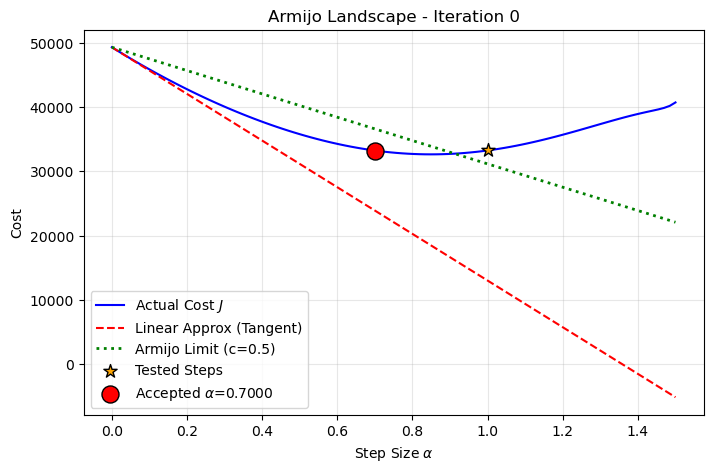

Iter 0: Cost 33247.9974 | Alpha 0.7000 | Slope -36364.44
Generating Armijo Plot for Iteration 1...


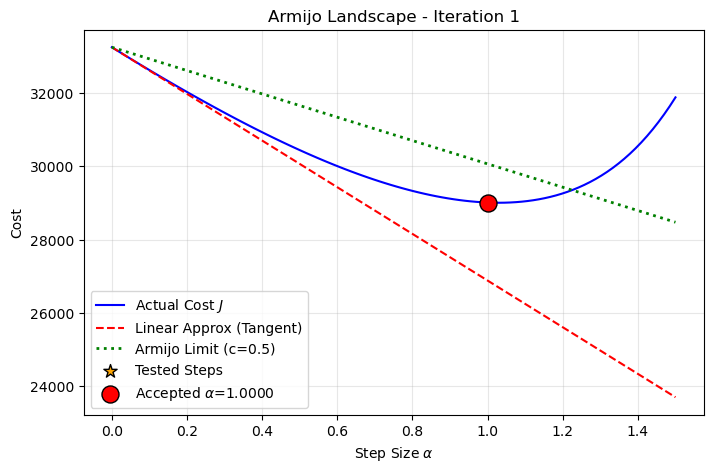

Iter 1: Cost 29012.8877 | Alpha 1.0000 | Slope -6362.98
Generating Armijo Plot for Iteration 2...


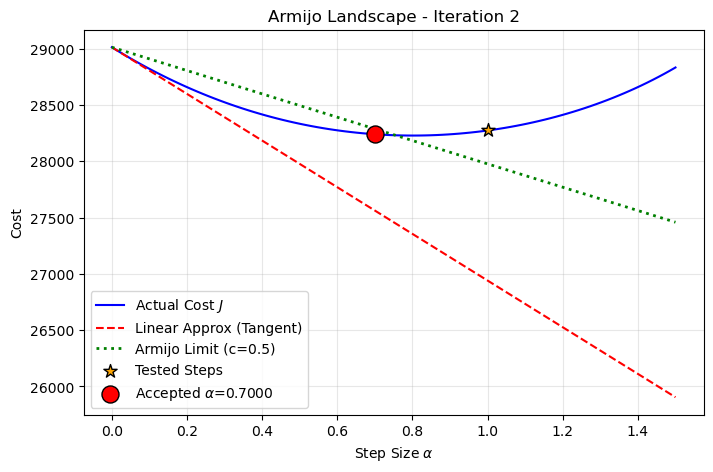

Iter 2: Cost 28240.1146 | Alpha 0.7000 | Slope -2072.18
Iter 3: Cost 27924.0614 | Alpha 1.0000 | Slope -490.95
Iter 4: Cost 27706.8802 | Alpha 1.0000 | Slope -396.52
Iter 5: Cost 27551.1210 | Alpha 0.7000 | Slope -351.61
Iter 6: Cost 27373.1775 | Alpha 1.0000 | Slope -264.26
Iter 7: Cost 27220.5306 | Alpha 1.0000 | Slope -273.64
Iter 8: Cost 27074.2531 | Alpha 0.7000 | Slope -375.75
Iter 9: Cost 26919.3210 | Alpha 1.0000 | Slope -220.93
Generating Armijo Plot for Iteration 10...


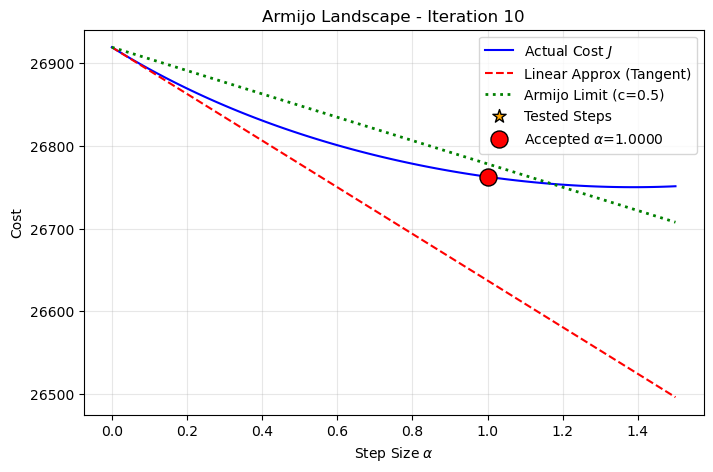

Iter 10: Cost 26762.6882 | Alpha 1.0000 | Slope -282.06
Iter 11: Cost 26633.4184 | Alpha 0.7000 | Slope -298.99
Iter 12: Cost 26481.1565 | Alpha 1.0000 | Slope -239.47
Iter 13: Cost 26338.7741 | Alpha 1.0000 | Slope -269.53
Iter 14: Cost 26198.5156 | Alpha 0.7000 | Slope -375.41
Iter 15: Cost 26046.1261 | Alpha 1.0000 | Slope -226.44
Iter 16: Cost 25897.3832 | Alpha 1.0000 | Slope -287.71
Iter 17: Cost 25757.9021 | Alpha 0.7000 | Slope -320.70
Iter 18: Cost 25609.3256 | Alpha 1.0000 | Slope -237.00
Iter 19: Cost 25447.8010 | Alpha 1.0000 | Slope -280.19
Generating Armijo Plot for Iteration 20...


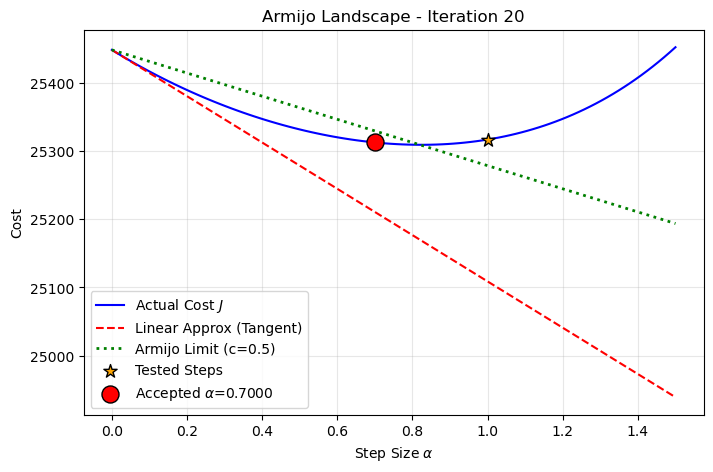

Iter 20: Cost 25312.2674 | Alpha 0.7000 | Slope -339.00
Iter 21: Cost 25144.7219 | Alpha 1.0000 | Slope -237.01
Iter 22: Cost 25001.6050 | Alpha 1.0000 | Slope -270.24
Iter 23: Cost 24824.3980 | Alpha 1.0000 | Slope -341.59
Iter 24: Cost 24693.0668 | Alpha 0.7000 | Slope -364.58
Iter 25: Cost 24514.9391 | Alpha 1.0000 | Slope -287.06
Iter 26: Cost 24387.6807 | Alpha 0.7000 | Slope -306.16
Iter 27: Cost 24207.6470 | Alpha 1.0000 | Slope -273.79
Iter 28: Cost 24079.3756 | Alpha 0.7000 | Slope -292.20
Iter 29: Cost 23899.5798 | Alpha 1.0000 | Slope -274.76
Generating Armijo Plot for Iteration 30...


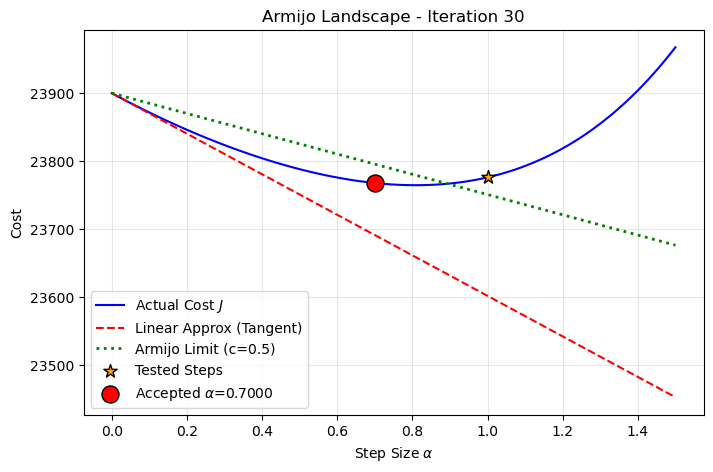

Iter 30: Cost 23767.5953 | Alpha 0.7000 | Slope -297.86
Iter 31: Cost 23588.2687 | Alpha 1.0000 | Slope -281.73
Iter 32: Cost 23450.5573 | Alpha 0.7000 | Slope -312.11
Iter 33: Cost 23269.9908 | Alpha 1.0000 | Slope -291.56
Iter 34: Cost 23124.4584 | Alpha 0.7000 | Slope -330.36
Iter 35: Cost 22939.0596 | Alpha 1.0000 | Slope -304.25
Iter 36: Cost 22782.7589 | Alpha 0.7000 | Slope -352.43
Iter 37: Cost 22586.7941 | Alpha 1.0000 | Slope -322.47
Iter 38: Cost 22414.8397 | Alpha 0.7000 | Slope -381.92
Iter 39: Cost 22199.6148 | Alpha 1.0000 | Slope -351.51
Generating Armijo Plot for Iteration 40...


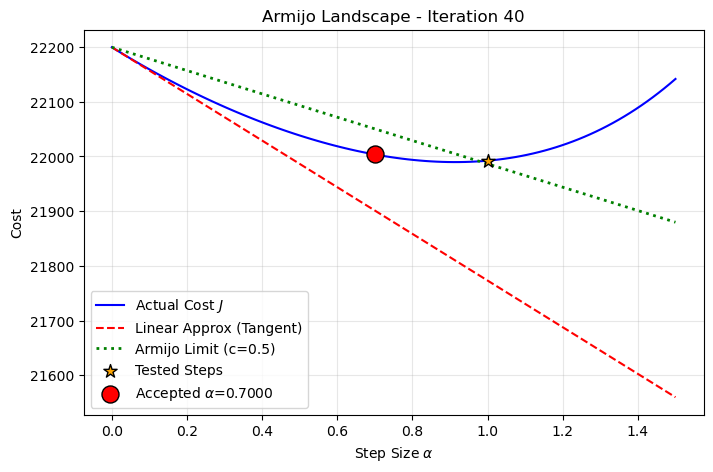

Iter 40: Cost 22003.5475 | Alpha 0.7000 | Slope -426.56
Iter 41: Cost 21755.7839 | Alpha 1.0000 | Slope -400.14
Iter 42: Cost 21503.2811 | Alpha 1.0000 | Slope -499.89
Iter 43: Cost 21205.7519 | Alpha 0.7000 | Slope -806.22
Iter 44: Cost 20885.5258 | Alpha 1.0000 | Slope -552.87
Iter 45: Cost 20518.2847 | Alpha 0.7000 | Slope -897.10
Iter 46: Cost 20091.8284 | Alpha 1.0000 | Slope -711.15
Iter 47: Cost 19600.0317 | Alpha 0.7000 | Slope -1135.86
Iter 48: Cost 19068.3683 | Alpha 1.0000 | Slope -998.24
Iter 49: Cost 18383.0445 | Alpha 0.7000 | Slope -1628.23


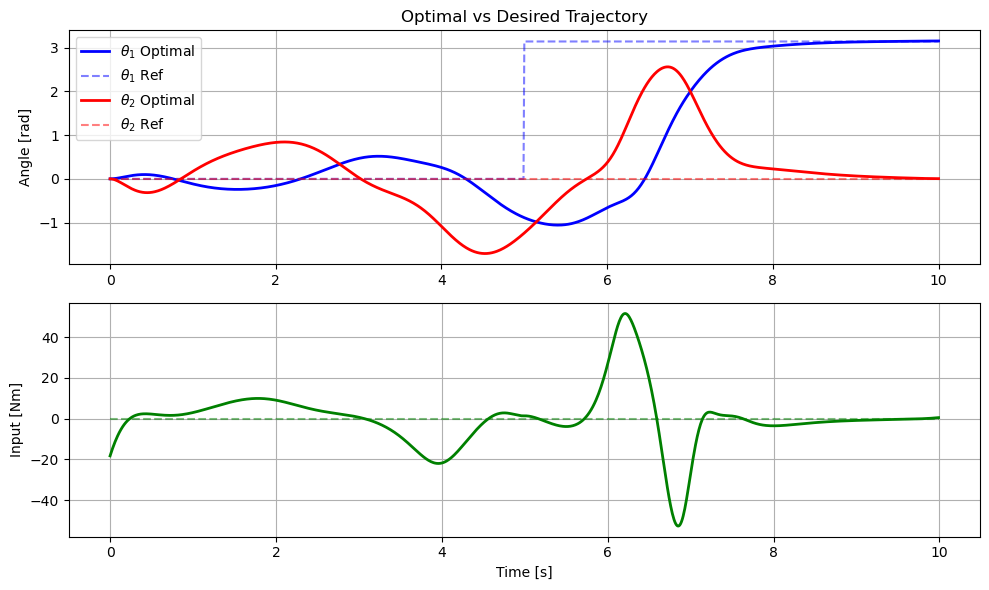

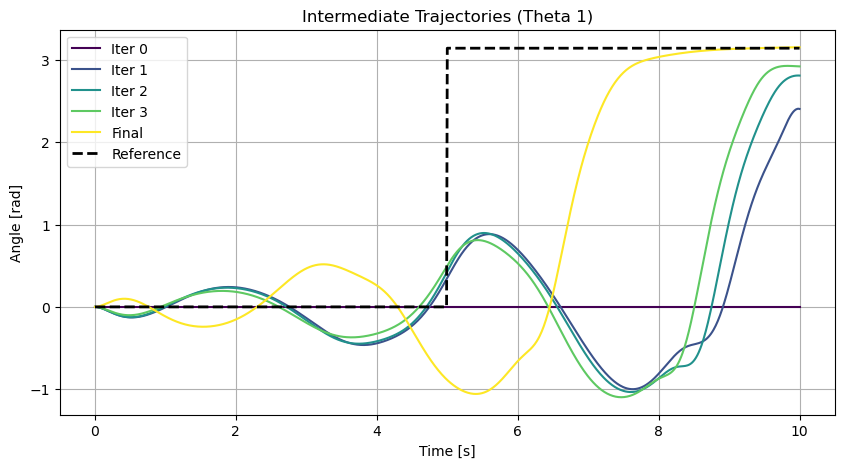

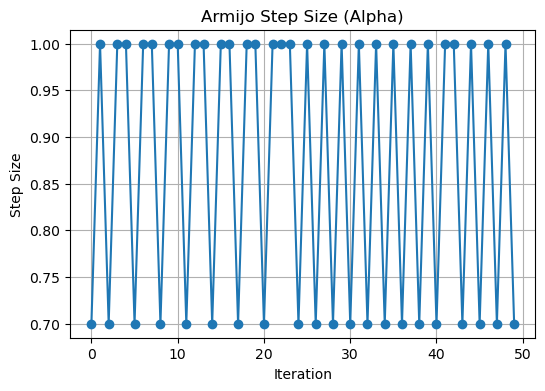

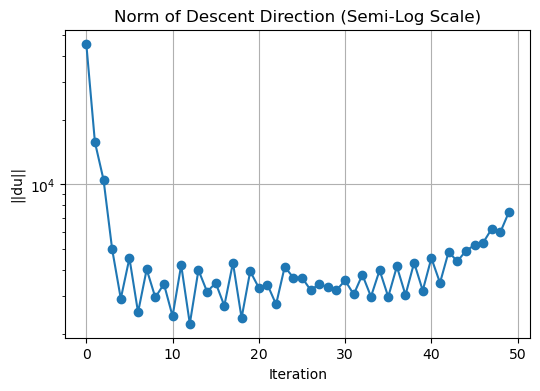

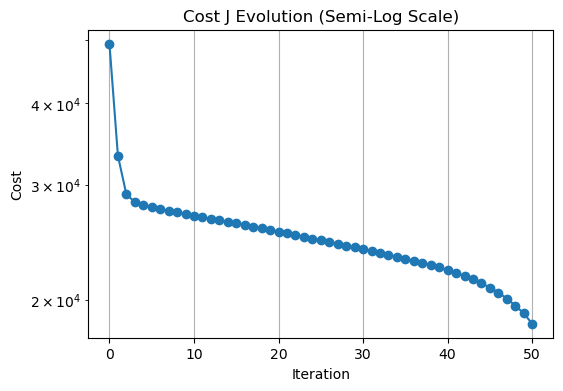

In [ ]:
# 1. Setup
robot = Acrobot()
solver = NewtonSolver(robot)

# 2. Equilibria & Ref
solver.compute_equilibria()
solver.generate_step_reference()

# 3. Solve
x_opt, u_opt = solver.solve(max_iters=50)

# --- PLOTTING SECTION ---
time = solver.time_grid

# Plot 1: Optimal vs Desired
plt.figure(figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(time, x_opt[:, 0], 'b-', linewidth=2, label=r'$\theta_1$ Optimal')
plt.plot(time, solver.x_ref[:, 0], 'b--', alpha=0.5, label=r'$\theta_1$ Ref')
plt.plot(time, x_opt[:, 1], 'r-', linewidth=2, label=r'$\theta_2$ Optimal')
plt.plot(time, solver.x_ref[:, 1], 'r--', alpha=0.5, label=r'$\theta_2$ Ref')
plt.ylabel('Angle [rad]')
plt.title('Optimal vs Desired Trajectory')
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(time[:-1], u_opt, 'g-', linewidth=2, label='Torque [Nm]')
plt.plot(time[:-1], solver.u_ref, 'g--', alpha=0.5, label='Torque Ref')
plt.ylabel('Input [Nm]')
plt.xlabel('Time [s]')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Intermediate Trajectories (The "Learning" Process)
plt.figure(figsize=(10, 5))
colors = plt.cm.viridis(np.linspace(0, 1, len(solver.intermediate_trajs)))
for idx, traj in enumerate(solver.intermediate_trajs):
    label = "Final" if idx == len(solver.intermediate_trajs)-1 else f"Iter {idx}"
    plt.plot(time, traj[:, 0], color=colors[idx], label=label) # Plotting Theta1 only for clarity
plt.plot(time, solver.x_ref[:, 0], 'k--', linewidth=2, label='Reference')
plt.title('Intermediate Trajectories (Theta 1)')
plt.xlabel('Time [s]')
plt.ylabel('Angle [rad]')
plt.legend()
plt.grid(True)
plt.show()

# Plot 3: Armijo Alphas
plt.figure(figsize=(6, 4))
plt.plot(solver.armijo_alphas, '-o')
plt.title('Armijo Step Size (Alpha)')
plt.xlabel('Iteration')
plt.ylabel('Step Size')
plt.grid(True)
plt.show()

# Plot 4: Norm of Descent Direction (Semi-Log Scale)
plt.figure(figsize=(6, 4))
plt.semilogy(solver.descent_norm_history, '-o')
plt.title('Norm of Descent Direction (Semi-Log Scale)')
plt.xlabel('Iteration')
plt.ylabel('||du||')
plt.grid(True)
plt.show()

# Plot 5: Cost Evolution (Semi-Log Scale)
plt.figure(figsize=(6, 4))
plt.semilogy(solver.cost_history, '-o')
plt.title('Cost J Evolution (Semi-Log Scale)')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.grid(True)
plt.show()